# Paper ST Sloping - 8 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import random
import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_8beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,30.571581,30.571114,30.597163,8.654545,1.254944,0.902949,-0.773465,-1.399254,-0.734867,...,-0.052333,0.042084,-0.051954,0.052820,-0.078516,0.018113,-0.033035,-0.008121,-0.004387,NSR
1,e0106,35.327463,37.090233,36.619925,10.318908,1.501561,0.936195,-0.694743,-1.301387,-0.880195,...,-0.025711,0.004880,-0.014158,0.033816,-0.052615,-0.010039,-0.020460,-0.003424,-0.010776,NSR
2,e0106,33.754220,34.253945,34.112950,9.653801,1.420377,0.922050,-0.707779,-1.271389,-0.778260,...,-0.041095,0.024671,-0.028207,0.045623,-0.069928,-0.007982,-0.010177,-0.011244,-0.007525,NSR
3,e0106,33.428166,32.277378,32.154651,9.225828,1.332695,0.898518,-0.728415,-1.302251,-0.708089,...,-0.053417,0.034100,-0.041100,0.034451,-0.060591,-0.005673,-0.010582,-0.020471,0.001472,NSR
4,e0106,34.438584,33.565638,33.382364,9.589036,1.426830,0.886530,-0.727896,-1.310174,-0.910833,...,-0.077430,0.064301,-0.063539,0.066193,-0.087852,0.018333,-0.028678,-0.022301,0.009486,NSR


In [5]:
data['label'].value_counts()

NSR    52426
ST-    10993
ST+     4936
Name: label, dtype: int64

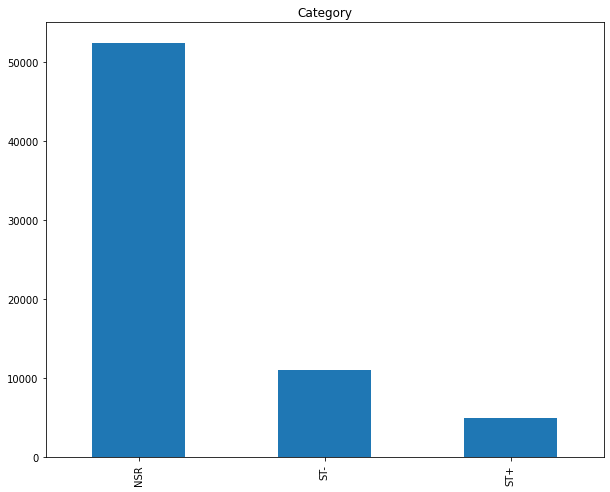

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.232673,0.111713,0.079107,0.076764,0.077147,-0.018860,0.030559,0.040220,-0.014666,...,-0.053028,-0.055461,-0.025675,-0.018685,-0.009704,-0.039241,-0.027948,-0.044903,-0.065581,-0.044688
dw_2,0.232673,1.000000,0.839282,0.452814,0.160598,0.424152,-0.484394,-0.404156,0.100065,0.435652,...,-0.136686,0.140104,0.232989,0.166906,0.045325,0.029218,0.115506,-0.000752,-0.115788,-0.079295
dw_3,0.111713,0.839282,1.000000,0.631576,0.240584,0.301445,-0.535593,-0.534332,-0.030329,0.564342,...,-0.206789,0.121560,0.266346,0.117884,-0.049549,0.051187,0.045371,-0.026800,-0.130477,-0.049044
dw_4,0.079107,0.452814,0.631576,1.000000,0.895025,0.016860,-0.237619,-0.260776,-0.029358,0.299563,...,-0.147248,0.048851,0.116574,0.042862,-0.044403,0.042171,0.026140,-0.032931,-0.089245,-0.033579
dw_5,0.076764,0.160598,0.240584,0.895025,1.000000,-0.105960,-0.011988,-0.035024,-0.012480,0.061799,...,-0.066765,0.004155,0.014207,0.013282,-0.012686,0.016035,0.013783,-0.034165,-0.041855,-0.018000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.039241,0.029218,0.051187,0.042171,0.016035,-0.094790,0.068312,0.129263,0.122377,-0.090957,...,-0.127261,-0.207625,-0.097674,0.019114,0.057081,1.000000,0.003281,-0.017734,-0.318789,-0.208539
cfr_13,-0.027948,0.115506,0.045371,0.026140,0.013783,0.077604,-0.004769,0.006963,0.049874,0.008203,...,0.128357,0.032112,-0.217503,-0.271096,-0.046139,0.003281,1.000000,0.186633,0.097077,-0.171867
cfr_14,-0.044903,-0.000752,-0.026800,-0.032931,-0.034165,0.032269,0.017775,0.034991,0.012523,-0.020623,...,0.096622,0.214725,0.044225,-0.177405,-0.291133,-0.017734,0.186633,1.000000,0.157260,-0.146906
cfr_15,-0.065581,-0.115788,-0.130477,-0.089245,-0.041855,0.009040,0.083235,0.080419,-0.058850,-0.098386,...,0.258472,0.163393,-0.078272,-0.146256,-0.095566,-0.318789,0.097077,0.157260,1.000000,0.229510


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_178', 'fft_140', 'fft_160', 'fft_175', 'fft_240', 'fft_245', 'fft_142', 'fft_144', 'fft_162', 'fft_181', 'fft_184', 'fft_213', 'fft_192', 'fft_159', 'fft_195', 'fft_224', 'fft_212', 'fft_170', 'fft_242', 'fft_147', 'fft_247', 'fft_167', 'fft_148', 'fft_231', 'fft_168', 'fft_137', 'fft_211', 'fft_203', 'fft_251', 'fft_255', 'fft_161', 'mfw_11', 'fft_136', 'fft_217', 'fft_171', 'fft_206', 'fft_185', 'fft_235', 'fft_253', 'fft_233', 'fft_209', 'fft_241', 'fft_216', 'fft_149', 'fft_225', 'fft_219', 'fft_145', 'fft_152', 'fft_244', 'fft_176', 'fft_186', 'fft_239', 'fft_196', 'fft_135', 'fft_214', 'fft_182', 'fft_237', 'fft_180', 'fft_204', 'fft_188', 'fft_198', 'fft_232', 'fft_139', 'fft_153', 'fft_226', 'fft_179', 'fft_166', 'fft_132', 'fft_197', 'fft_193', 'fft_199', 'fft_248', 'fft_150', 'fft_191', 'fft_194', 'fft_143', 'fft_221', 'fft_229', 'fft_133', 'fft_201', 'fft_249', 'fft_174', 'fft_130', 'fft_146', 'fft_183', 'fft_252', 'fft_169', 'fft_155', 'fft_131', 'fft_189', 'fft_222',

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
mfw_5
mfw_6
mfw_7
mfw_8
mfw_9
mfw_10
mfw_12
mfw_13
mfw_14
mfw_15
mfw_16
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_20
fft_21
fft_22
fft_23
fft_24
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_12
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 79


### Visualization best features

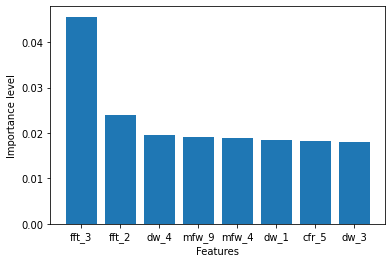

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,30.571581,30.571114,30.597163,8.654545,1.254944,0.902949,-0.773465,-1.399254,-0.734867,12.762118,...,0.012196,0.047766,-0.052333,0.042084,-0.051954,0.052820,-0.078516,0.018113,-0.033035,-0.008121
1,35.327463,37.090233,36.619925,10.318908,1.501561,0.936195,-0.694743,-1.301387,-0.880195,10.573212,...,0.022624,0.032716,-0.025711,0.004880,-0.014158,0.033816,-0.052615,-0.010039,-0.020460,-0.003424
2,33.754220,34.253945,34.112950,9.653801,1.420377,0.922050,-0.707779,-1.271389,-0.778260,10.515795,...,0.010279,0.036796,-0.041095,0.024671,-0.028207,0.045623,-0.069928,-0.007982,-0.010177,-0.011244
3,33.428166,32.277378,32.154651,9.225828,1.332695,0.898518,-0.728415,-1.302251,-0.708089,11.496901,...,0.005352,0.048697,-0.053417,0.034100,-0.041100,0.034451,-0.060591,-0.005673,-0.010582,-0.020471
4,34.438584,33.565638,33.382364,9.589036,1.426830,0.886530,-0.727896,-1.310174,-0.910833,10.732432,...,-0.003147,0.052752,-0.077430,0.064301,-0.063539,0.066193,-0.087852,0.018333,-0.028678,-0.022301


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, seed in enumerate(seeds):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=seed)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(seeds), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 15.774381875991821 s
Tot: Accuracy 0.9193182649403847 Precision 0.9198969993743285 Recall 0.9193182649403847 Specificity 0.7805477568623175 F1 0.9150170483866226
NSR: Accuracy 0.9194645600175554 Precision 0.9178890876565295 Recall 0.982479655337482 Specificity 0.7154370737755734 F1 0.9490867052023122
ST+: Accuracy 0.982517738278107 Precision 0.9170506912442397 Recall 0.8265835929387332 Specificity 0.9943342776203966 F1 0.8694702348443475
ST-: Accuracy 0.982517738278107 precision 0.9303758471965496 Recall 0.6672558550596553 Specificity 0.9900946704067322 F1 0.7771487390633043
#---------------------#
#---------------------#
2 of 1000 - 15.933550119400024 s
Tot: Accuracy 0.9239265598712604 Precision 0.9239744569807988 Recall 0.9239265598712604 Specificity 0.792118983644079 F1 0.9203325100141913
NSR: Accuracy 0.9243654451027723 Precision 0.9238692342140618 Recall 0.9824745213829889 Specificity 0.7320302648171501 F1 0.9522710487444609
ST+: Accuracy 0.9816

In [18]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.919318,0.919897,0.919318,0.780548,0.915017,0.919465,0.917889,0.982480,0.715437,0.949087,0.982518,0.917051,0.826584,0.994334,0.869470,0.982518,0.930376,0.667256,0.990095,0.777149
1,0.923927,0.923974,0.923927,0.792119,0.920333,0.924365,0.923869,0.982475,0.732030,0.952271,0.981640,0.921659,0.813835,0.994641,0.864398,0.981640,0.925519,0.692554,0.989375,0.792265
2,0.920635,0.921766,0.920635,0.780924,0.916477,0.920708,0.917627,0.984472,0.715256,0.949875,0.980982,0.919664,0.798958,0.994729,0.855072,0.980982,0.941606,0.679543,0.991574,0.789393
3,0.923634,0.924294,0.923634,0.788652,0.919823,0.923707,0.922678,0.983048,0.727215,0.951907,0.982371,0.905594,0.829242,0.993639,0.865738,0.982371,0.939729,0.683975,0.991431,0.791710
4,0.925024,0.925321,0.925024,0.789867,0.921321,0.925463,0.923784,0.984310,0.729319,0.953087,0.982518,0.934834,0.810894,0.995669,0.868465,0.982518,0.928483,0.690192,0.989903,0.791798
5,0.924804,0.925643,0.924804,0.791761,0.920989,0.924951,0.922361,0.984798,0.730075,0.952557,0.982737,0.926719,0.827795,0.994873,0.874468,0.982737,0.940631,0.685444,0.991617,0.793014
6,0.924804,0.924748,0.924804,0.795981,0.921325,0.925024,0.925437,0.981538,0.737275,0.952662,0.981713,0.915584,0.831041,0.993835,0.871267,0.981713,0.925718,0.691375,0.989676,0.791567
7,0.925390,0.925750,0.925390,0.800898,0.921918,0.925536,0.924506,0.982648,0.741667,0.952691,0.982957,0.921081,0.841897,0.994233,0.879711,0.982957,0.933695,0.695242,0.990387,0.797016
8,0.925024,0.924505,0.925024,0.801211,0.921983,0.925097,0.927793,0.978911,0.744911,0.952667,0.980835,0.904656,0.822581,0.993217,0.861668,0.980835,0.917569,0.708643,0.988107,0.799685
9,0.920562,0.920645,0.920562,0.788302,0.916808,0.920708,0.920963,0.980493,0.726113,0.949796,0.979592,0.906926,0.812803,0.993196,0.857289,0.979592,0.925604,0.684235,0.989555,0.786825


In [19]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_8beats_1000x_random_split.csv')

######## Total ########
Accuracy 0.924470997000951
Precision 0.9246956871035251
Recall 0.924470997000951
Specificity 0.7942660400368818
F1 0.9208706180555648
######## NSR ########
Accuracy 0.9246774193548388
Precision 0.9241154172289471
Recall 0.9824773146908911
Specificity 0.7343954482309917
F1 0.9524007260286097
######## ST+ ########
Accuracy 0.9823723209713994
Precision 0.9189112194892898
Recall 0.8294090275942967
Specificity 0.9942944423427679
F1 0.8718047354216394
######## ST- ########
Accuracy 0.9823723209713994
Precision 0.9299725014782976
Recall 0.6903765596337242
Specificity 0.9900471464640734
F1 0.7924129504622772
